# Распространение тепла

### Условие задачи

**Дано:**
- твердое тело, в массе которого распространяется тепло от нескольких источников
- тело - тонкая пластина $[0, L] x [0, L]$ с коэффициентом диффузии $D = 1.0$
- в центре пластины расположен круг радиуса $R = L/5$ с низким коэффициентом диффузии $D_R = 10^{-12}$
- $T_0 = 0$ - начальная температура во всем объеме пластины
- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = L$
    - абсолютная теплоизоляция на ребрах
        - $x = L$
        - $y = 0$ 
- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t + \phi_i) + 1)$

    - источник 0:
        - центр $(0.2L, 0.5L)$
        - размеры (от центра до края) $(L/25, 0.2L)$
        - $p_0 = 100$, $\theta_0 = 50$, $\phi_0 = 0$
        
    - источник 1:
        - центр $(0.5L, 0.2L)$
        - размеры (от центра до края) $(0.2L, L/25, 0.2L)$
        - $p_0 = 100$, $\theta_0 = 77$, $\phi_0 = 10$
    
- координаты проб, для которых необходимо построить графики изменения температуры от времени
    - проба 0: $(0.3L, 0.3L)$
    - проба 1: $(0.3L, 0.7L)$
    - проба 2: $(0.7L, 0.7L)$
    - проба 3: $(0.7L, 0.3L)$
    
- $dx = L / N$ - шаг пространственного разбиения по всем измерениям
- $t_m = 600$ c - общее время моделирования

<table><tr><td>
<img src="heat_transfer_task.png"/>
<center>Рис. 1. Схематическое изображение пластины</center>
</td></tr></table>


- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ при:
    - $L = 100$
    - $(N, dt) \in [(100, 0.05), (300, 0.02), (700, 0.005), (2000, 0.0005)]$
    
    
- для каждой пары $(N, dt)$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**

    3. построить цветовую карту в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу (colorbar),
        - отобразить пробы в виде точек и подписать их номера.

    4. на одном рисунке построить графики температур в местах установки проб
        - подписать оси,
        - вывести легенду.

    5. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`



**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


In [1]:
import numpy as np
import numba as nb
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
import imageio

from tqdm import trange, tqdm
from time import perf_counter
from contextlib import contextmanager

In [ ]:
@contextmanager
def catchtime() -> float:
    """
    Measures elapsed time for code executed inside the context manager.
    param: None
    returns: float, code execution time
    """
    start = perf_counter()
    yield lambda: perf_counter() - start

In [ ]:
L = 100
N_opt, dt_opt = zip((100,0.05),(300,0.02),(700,0.005),(2000,0.0005))

D_default = 1
D_center = 1e-12
dt, N = dt_opt[0], N_opt[0]

### Model definition

In [ ]:
@nb.njit(parallel = True)
def diffuse_step_fast(ti, T, D, N, dt, dx):
    """
    Calculates next step of heat transfer model via differential heat equation,
    implementing finite-difference method with respect to diffusion coefficients
    """
    ti = ti % 2
    tj = (ti + 1) % 2
    for i in nb.prange(1, N - 1):
        for j in range(1, N - 1):       
            g = dt * D[i, j] / dx**2
            T[tj, i, j] = T[ti, i, j] + \
                     g * (T[ti, i+1, j] + 
                          T[ti, i-1, j] + 
                          T[ti, i, j+1] + 
                          T[ti, i, j-1] -
                          4 * T[ti, i, j])

In [ ]:
class PowerSource:
    """Power Source structure for HeatTransferModel"""
    
    def __init__(self, x_c, y_c, x_s, y_s, f, dx):
        self.position = np.array([x_c / dx, y_c / dx], dtype=int)
        self.size = np.array([x_s / dx, y_s / dx], dtype=int)
        self.power = f


class HeatTransferModel:
    """HeatTransferModel for solving heat equation by finite-difference method"""
    
    def __init__(self, L, N, D_default, dt):
        self.L = L
        self.N = N
        self.dx = L / N
        self.D = np.full((N, N), D_default)
        self.T = np.zeros((2, N, N), dtype=float)
        self.dt = dt
        self.power_sources = []
    
    def isolation(self):
        """
        Apply the fixed isolation on edges strategy to model
        """
        self.T[:,  0, :] = self.T[:,  1, :]
        self.T[:, -1, :] = self.T[:, -2, :]
        self.T[:, :,  0] = self.T[:, :,  1]
        self.T[:, :, -1] = self.T[:, :, -2]
    
    def add_power_source(self, x_c, y_c, x_s, y_s, f):
        """
        Add the power source to model, creating it through structure PowerSource
        """
        s = PowerSource(x_c, y_c, x_s, y_s, f, self.dx)
        self.power_sources.append(s)
    
    def source_step(self, it):
        """
        Calculate the added heat from all the power sources in model, using their
        heat functions and sizes
        """
        cur = it % 2
        for s in self.power_sources:
            left = s.position[1] - s.size[1]
            right = left + 2 * s.size[1]
            bottom = s.position[0] - s.size[0]
            top = bottom + 2 * s.size[0]
            self.T[cur, bottom:top, left:right] += self.dt * s.power(it * self.dt)
    
    def step(self, it):
        """
        Perform a complete step on model, calculating heat diffusion and heat source effect
        """
        self.source_step(it)
        diffuse_step_fast(it, self.T, self.D, self.N, self.dt, self.dx)
        self.isolation()
        return self.T[(it + 1) % 2]

In [ ]:
def power_first(dt):
    """Periodic power function for first source"""
    p, teta, phi = 100, 50, 0
    return p * (np.sin(2 * np.pi * dt / teta + phi) + 1)

def power_second(dt):
    """Periodic power function for second source"""
    p, teta, phi = 100, 77, 10
    return p * (np.sin(2 * np.pi * dt / teta + phi) + 1)

In [2]:
opts = zip(N_opt[:1], dt_opt[:1])

In [3]:
for index, (N, dt) in enumerate(opts):
    model = HeatTransferModel(100, N, D_default, dt)

    model.add_power_source(0.2*L, 0.5*L, L/25, 0.2*L, power_first)
    model.add_power_source(0.5*L, 0.2*L, 0.2*L, L/25, power_second)

    model.T[:,  0,  :] = 0.0
    model.T[:, -1,  :] = 50.0
    model.T[:,  :,  0] = 50.0
    model.T[:,  :, -1] = 0.0

    probes = {0: (int((0.3*L) // model.dx), int((0.3*L) // model.dx)),
              1: (int((0.3*L) // model.dx), int((0.7*L) // model.dx)),
              2: (int((0.7*L) // model.dx), int((0.7*L) // model.dx)),
              3: (int((0.7*L) // model.dx), int((0.3*L) // model.dx))}

    # задаем круг в центре с плохой проводимостью тепла

    R = (L / 5) // model.dx
    for i in range(model.N):
        for j in range(model.N):
            if (i-N//2)**2 + (j-N//2)**2 <= R**2:
                model.D[i, j] = D_center

    max_time = 1800.0
    iterations = int(max_time / dt)

    probe_values = np.empty((4, iterations))
    
    with catchtime() as t:
        for i in trange(iterations):
            T = model.step(i)
            if i % 100 == 0:
                plt.suptitle('Heatmap')
                plt.figure(figsize=(10, 8))
                graphic = plt.pcolormesh(T, cmap='magma')
                plt.legend()
                plt.savefig(f'{i}.png')
            for j, (x, y) in probes.items():
                probe_values[j, i] = T[x, y]
    print(f"Execution time on {(N, dt)}: {t():.4f} secs")

    np.save('T_'+str(index)+'.npy', T)
    np.save('Probe_coord_'+str(index)+'.npy', np.array([list(x) for x in probes.values()]))
    np.save('Prob_'+str(index)+'.npy', probe_values)

In [40]:
N = 600
dt = 0.005
model = HeatTransferModel(100, N, D_default, dt)

model.add_power_source(0.2*L, 0.5*L, L/25, 0.2*L, power_first)
model.add_power_source(0.5*L, 0.2*L, 0.2*L, L/25, power_second)

model.T[:,  0,  :] = 0.0
model.T[:, -1,  :] = 50.0
model.T[:,  :,  0] = 50.0
model.T[:,  :, -1] = 0.0


# задаем круг в центре с плохой проводимостью тепла

R = (L / 5) // model.dx
for i in range(model.N):
    for j in range(model.N):
        if (i-model.N//2)**2 + (j-model.N//2)**2 <= R**2:
            model.D[i, j] = D_center

max_time = 1800.0
iterations = int(max_time / dt)

with catchtime() as t:
    for i in trange(iterations):
        T = model.step(i)
        if i % 300 == 0:
            plt.figure(figsize=(10, 10))
            graphic = plt.pcolormesh(T, cmap='magma')
            plt.axis('off')
            plt.savefig(f'pics/{i}.png', bbox_inches='tight')
            plt.close()

print(f"Execution time on {(N, dt)}: {t():.4f} secs")

100%|██████████████████████████████████| 360000/360000 [06:04<00:00, 986.37it/s]

Execution time on (600, 0.005): 364.9806 secs


<table><tr><td>
<img src="time.png"/>
<center>Execution time</center>
</td></tr></table>

### Making GIFs

In [41]:
filenames = [str(f'pics/{i}.png') for i in range(0, 360000, 300)]

with imageio.get_writer('bober.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

/var/folders/r9/5px6351n6fx3yqdywn2tdlqs14pvmr/T/ipykernel_6235/2405146553.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [42]:
import os
for filename in set(filenames):
    os.remove(filename)

### Period Approximation

In [13]:
def approximate_period(arr, dt):
    """Approximate period for an array of data using Fast Fourier Transforms and peak search"""
    N = arr.size
    r = np.fft.rfft(arr - arr.mean())
    amp = (np.abs(r) / (N / 2))[:50]
    freq = np.fft.rfftfreq(N, dt)[:50]
    idx, h = signal.find_peaks(amp)
    return 1 / freq[idx]

In [14]:
probe_names = {0: '0.3L, 0.3L',
               1: '0.3L, 0.7L',
               2: '0.7L, 0.7L',
               3: '0.7L, 0.3L'}

### N = 100, dt = 0.05

Периоды пробы 0.3L, 0.3L - [900.         360.          78.26086957  50.        ]
Периоды пробы 0.3L, 0.7L - [900. 360.  50.]
Периоды пробы 0.7L, 0.7L - [900.]
Периоды пробы 0.7L, 0.3L - [900.         360.          78.26086957]


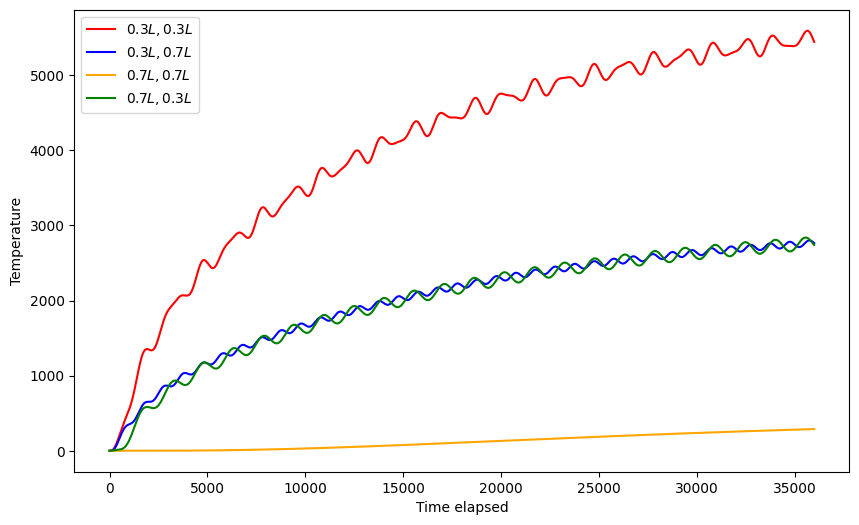

<Figure size 640x480 with 0 Axes>

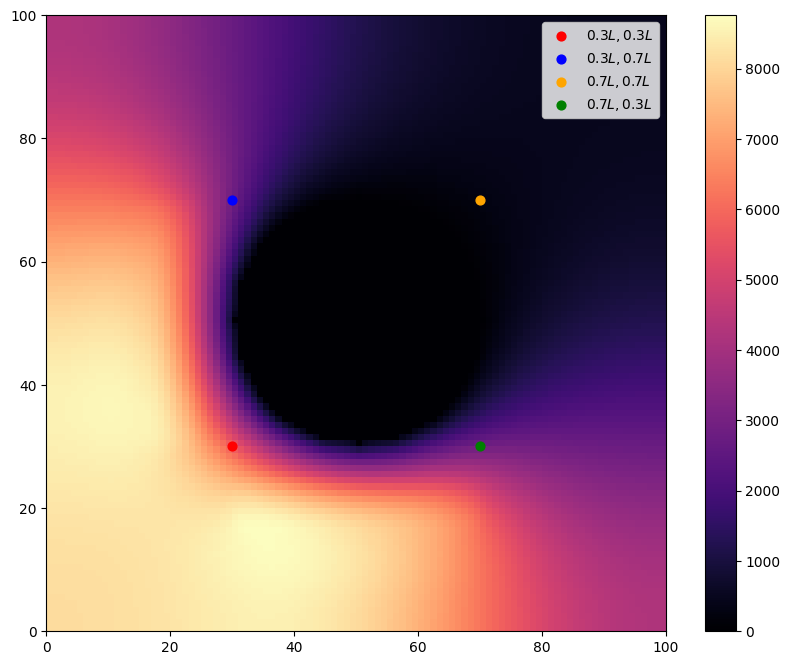

In [15]:
i = 0
dt = dt_opt[i]

probe_values = np.load('Prob_'+str(i) +'.npy')

for j in range(4):
    y = probe_values[j]
    x = np.arange(len(y))
    y_approx = np.poly1d(np.polyfit(x, y, deg=4))(x)
    detrended = y - y_approx
    periods = approximate_period(detrended, dt)
    print('Периоды пробы', probe_names[j], '-', periods)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'orange', 'green']
for j, color in zip(range(4), colors):
    plt.plot(probe_values[j], label='$'+probe_names[j]+'$', color=color)

plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show()

T = np.load('T_'+str(i) +'.npy')
probes = np.load('Probe_coord_'+str(i)+'.npy')
plt.suptitle('Heatmap')
plt.figure(figsize=(10, 8))
graphic = plt.pcolormesh(T, cmap='magma')
for j, color in zip(range(4), colors):
    xs = probes[j]
    plt.scatter(*xs, label='$'+probe_names[j]+'$', color=color, s=40)
plt.colorbar(graphic)
plt.legend()
plt.show()

### N = 300, dt = 0.02

Периоды пробы 0.3L, 0.3L - [900.         360.          78.26086957  50.        ]
Периоды пробы 0.3L, 0.7L - [900. 360.  50.]
Периоды пробы 0.7L, 0.7L - [900.]
Периоды пробы 0.7L, 0.3L - [900.         360.          78.26086957]


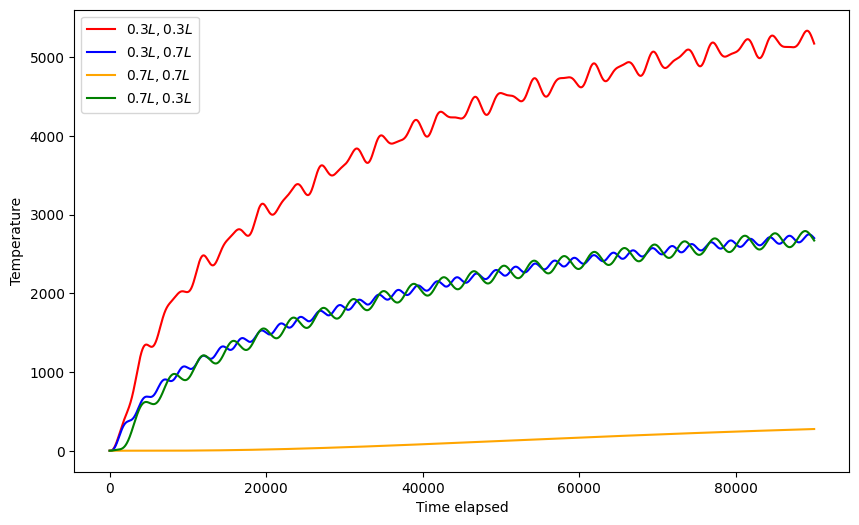

<Figure size 640x480 with 0 Axes>

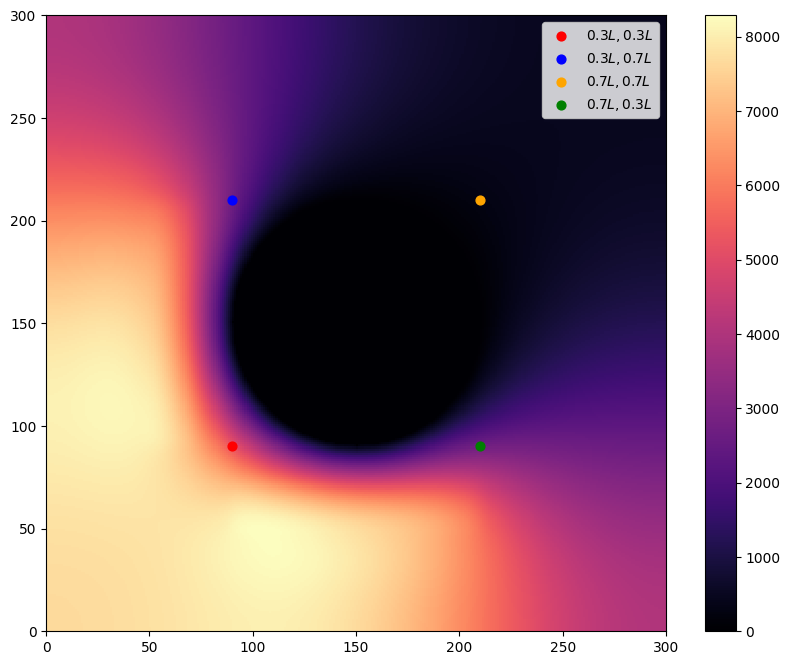

In [16]:
i = 1
dt = dt_opt[i]

probe_values = np.load('Prob_'+str(i) +'.npy')

for j in range(4):
    y = probe_values[j]
    x = np.arange(len(y))
    y_approx = np.poly1d(np.polyfit(x, y, deg=4))(x)
    detrended = y - y_approx
    periods = approximate_period(detrended, dt)
    print('Периоды пробы', probe_names[j], '-', periods)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'orange', 'green']
for j, color in zip(range(4), colors):
    plt.plot(probe_values[j], label='$'+probe_names[j]+'$', color=color)

plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show()

T = np.load('T_'+str(i) +'.npy')
probes = np.load('Probe_coord_'+str(i)+'.npy')
plt.suptitle('Heatmap')
plt.figure(figsize=(10, 8))
graphic = plt.pcolormesh(T, cmap='magma')
for j, color in zip(range(4), colors):
    xs = probes[j]
    plt.scatter(*xs, label='$'+probe_names[j]+'$', color=color, s=40)
plt.colorbar(graphic)
plt.legend()
plt.show()

### N = 700, dt = 0.005

Периоды пробы 0.3L, 0.3L - [75. 50.]
Периоды пробы 0.3L, 0.7L - [300. 100.  50.]
Периоды пробы 0.7L, 0.7L - [300. 150.]
Периоды пробы 0.7L, 0.3L - [150.  75.]


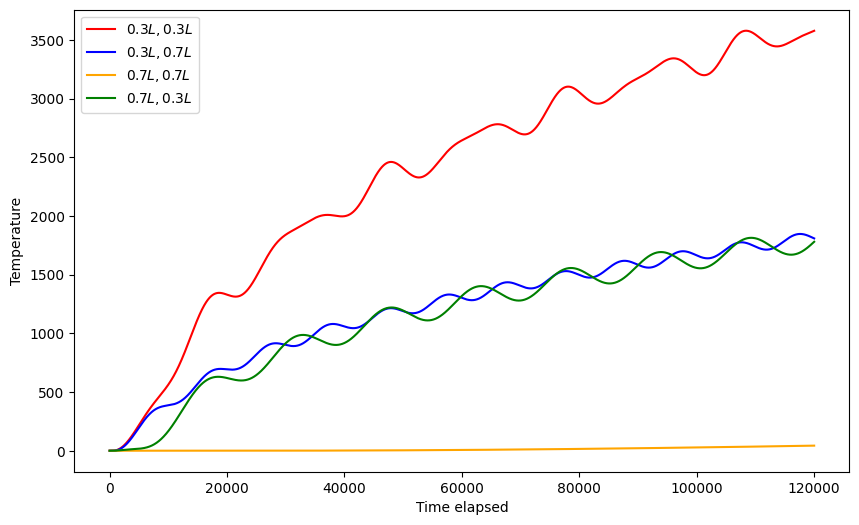

<Figure size 640x480 with 0 Axes>

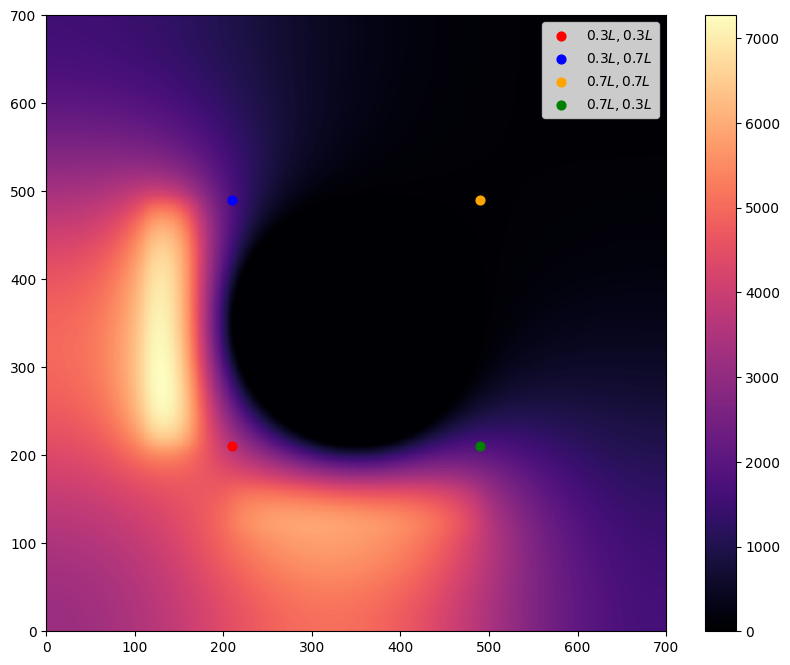

In [48]:
i = 2
dt = dt_opt[i]

probe_values = np.load('Prob_'+str(i) +'.npy')

for j in range(4):
    y = probe_values[j]
    x = np.arange(len(y))
    y_approx = np.poly1d(np.polyfit(x, y, deg=4))(x)
    detrended = y - y_approx
    periods = approximate_period(detrended, dt)
    print('Периоды пробы', probe_names[j], '-', periods)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'orange', 'green']
for j, color in zip(range(4), colors):
    plt.plot(probe_values[j], label='$'+probe_names[j]+'$', color=color)

plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show()

T = np.load('T_'+str(i) +'.npy')
probes = np.load('Probe_coord_'+str(i)+'.npy')
plt.suptitle('Heatmap')
plt.figure(figsize=(10, 8))
graphic = plt.pcolormesh(T, cmap='magma')
for j, color in zip(range(4), colors):
    xs = probes[j]
    plt.scatter(*xs, label='$'+probe_names[j]+'$', color=color, s=40)
plt.colorbar(graphic)
plt.legend()
plt.show()

### N = 2000, dt = 0.0005

Периоды пробы 0.3L, 0.3L - [75. 50.]
Периоды пробы 0.3L, 0.7L - [300. 100.  50.]
Периоды пробы 0.7L, 0.7L - [300. 150.]
Периоды пробы 0.7L, 0.3L - [150.  75.]


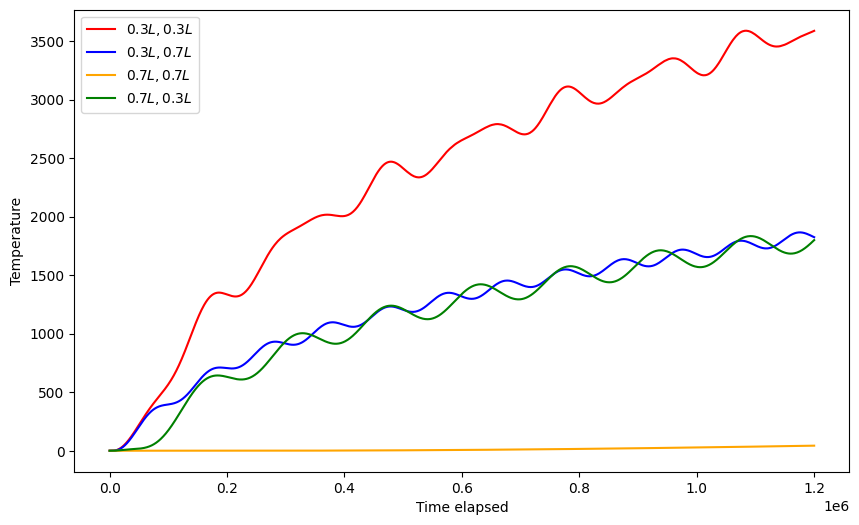

<Figure size 640x480 with 0 Axes>

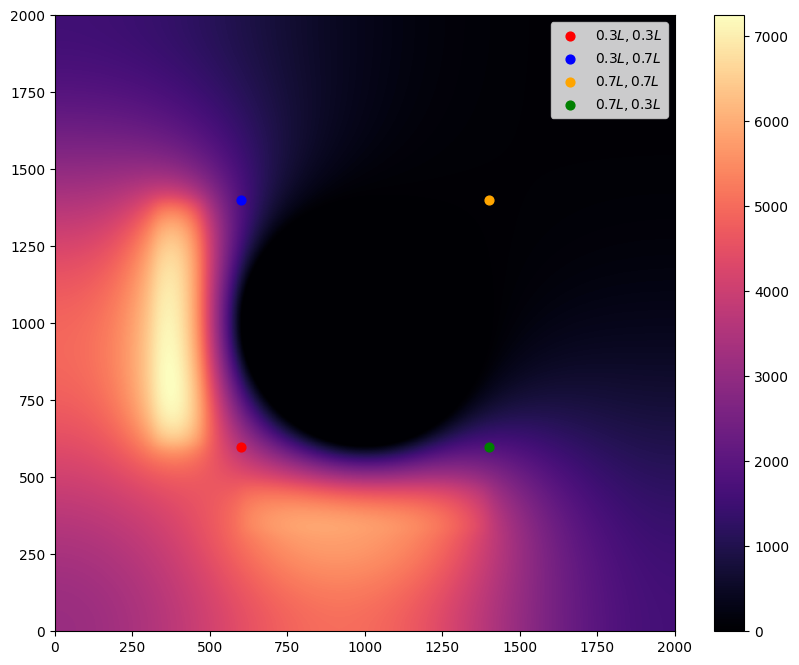

In [49]:
i = 3
dt = dt_opt[i]

probe_values = np.load('Prob_'+str(i) +'.npy')

for j in range(4):
    y = probe_values[j]
    x = np.arange(len(y))
    y_approx = np.poly1d(np.polyfit(x, y, deg=4))(x)
    detrended = y - y_approx
    periods = approximate_period(detrended, dt)
    print('Периоды пробы', probe_names[j], '-', periods)

plt.show()    
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'orange', 'green']
for j, color in zip(range(4), colors):
    plt.plot(probe_values[j], label='$'+probe_names[j]+'$', color=color)

plt.xlabel('Time elapsed')
plt.ylabel('Temperature')
plt.legend()
plt.show()

T = np.load('T_'+str(i) +'.npy')
probes = np.load('Probe_coord_'+str(i)+'.npy')
plt.suptitle('Heatmap')
plt.figure(figsize=(10, 8))
graphic = plt.pcolormesh(T, cmap='magma')
for j, color in zip(range(4), colors):
    xs = probes[j]
    plt.scatter(*xs, label='$'+probe_names[j]+'$', color=color, s=40)
plt.colorbar(graphic)
plt.legend()
plt.show()